In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import MaxPooling2D 
from keras.layers import Flatten
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score
import pandas as pd

In [3]:
dataFrame = pd.read_csv('/content/gdrive/MyDrive/Project/Dataset/fer2013.csv')
dataFrame.shape

(35887, 3)

In [4]:
dataFrame.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
def load_data(dataset_path):
  train_data = []
  train_labels =[]
  test_data = []
  test_labels = []
  
  with open(dataset_path, 'r') as file:
      for line_no, line in enumerate(file.readlines()):
          if 0 < line_no <= 35887:
            curr_class, line, set_type = line.split(',')
            image_data = np.asarray([int(x) for x in line.split()]).reshape(48, 48)
            image_data =image_data.astype(np.uint8)/255.0
            
            if (set_type.strip() == 'Training' or set_type.strip() == 'PrivateTest'):
              train_data.append(image_data)
              train_labels.append(curr_class)
            else:
              test_data.append(image_data)
              test_labels.append(curr_class)

      train_data = np.expand_dims(train_data, -1)   
      train_labels = to_categorical(train_labels, num_classes = 7)
      test_data = np.expand_dims(test_data, -1)
      test_labels = to_categorical(test_labels, num_classes = 7)
    
      return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)

In [6]:
def define_model():
  model = Sequential()
  model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)))
  model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
  model.add(Dropout(0.5))
      
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
      
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
      
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
      
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(7, activation='softmax'))
  return model

In [7]:
data_dir = '/content/gdrive/MyDrive/Project/Dataset/fer2013.csv'
train_data, train_labels, test_data, test_labels = load_data(data_dir)

In [8]:
model = define_model()
epochs = 100
batch_size = 128
learning_rate = 0.001
adam = optimizers.Adam(lr = learning_rate)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [9]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)
early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=6, mode='auto')
checkpointer = ModelCheckpoint('/content/gdrive/MyDrive/Project/Dataset/weights.hd5', monitor='val_loss', verbose=1, save_best_only=True)

In [10]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 128)       5

In [ ]:
model.fit(
          train_data,
          train_labels,
          epochs = epochs,
          batch_size = batch_size,
          validation_split = 0.2,
          shuffle = True,
          callbacks=[lr_reducer, checkpointer, early_stopper]
          )

Epoch 1/10
202/202 [==============================] - 27s 132ms/step - loss: 0.1869 - accuracy: 0.9448 - val_loss: 2.5604 - val_accuracy: 0.6361

Epoch 00001: val_loss improved from inf to 2.56040, saving model to /content/gdrive/MyDrive/Project/Dataset/weights.hd5
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Project/Dataset/weights.hd5/assets
Epoch 2/10
202/202 [==============================] - 23s 115ms/step - loss: 0.1846 - accuracy: 0.9450 - val_loss: 2.8927 - val_accuracy: 0.6454

Epoch 00002: val_loss did not improve from 2.56040
Epoch 3/10
202/202 [==============================] - 23s 116ms/step - loss: 0.1978 - accuracy: 0.9415 - val_loss: 2.5526 - val_accuracy: 0.6427

Epoch 00003: val_loss improved from 2.56040 to 2.55262, saving model to /content/gdrive/MyDrive/Project/Dataset/weights.hd5
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Project/Dataset/weights.hd5/assets
Epoch 4/10
202/202 [==============================] - 23s 116ms/step - loss: 0.

In [ ]:
from keras.models import model_from_json
model_json = model.to_json()
with open("/content/gdrive/MyDrive/Project/Dataset/FERmodel1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/gdrive/MyDrive/Project/Dataset/FERmodel1.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Server side

In [11]:
from keras.models import load_model
model.load_weights('/content/gdrive/MyDrive/Project/Dataset/FERmodel.h5')

In [12]:
predicted_test_labels = np.argmax(model.predict(test_data), axis=1)
test_labels1 = np.argmax(test_labels, axis=1)
print ("Accuracy score = ", accuracy_score(test_labels1, predicted_test_labels))

Accuracy score =  0.6310950125383115


In [13]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 8.7MB/s 


In [14]:
from time import sleep
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np
from mtcnn.mtcnn import MTCNN
from google.colab.patches import cv2_imshow

def get_emotion(imgLocation):
    detector = MTCNN()
    img = cv2.imread(imgLocation)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    class_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
    # 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

    faces = detector.detect_faces(img)
    for result in faces:
        x, y, w, h = result['box']
        x1, y1 = x + w, y + h
        cv2.rectangle(img, (x, y), (x1, y1), (0, 0, 255), 2)
        roi_gray = gray[y:y+h,x:x+w]
        roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)
        if np.sum([roi_gray])!=0:
            roi = roi_gray.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)
        # make a prediction on the ROI, then lookup the class
            preds = model.predict(roi)[0]
            label=class_labels[preds.argmax()]
            label_position = (x,y)
            cv2.putText(img,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
        else:
            cv2.putText(img,'No Face Found',(20,60),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
    cv2_imshow(img)

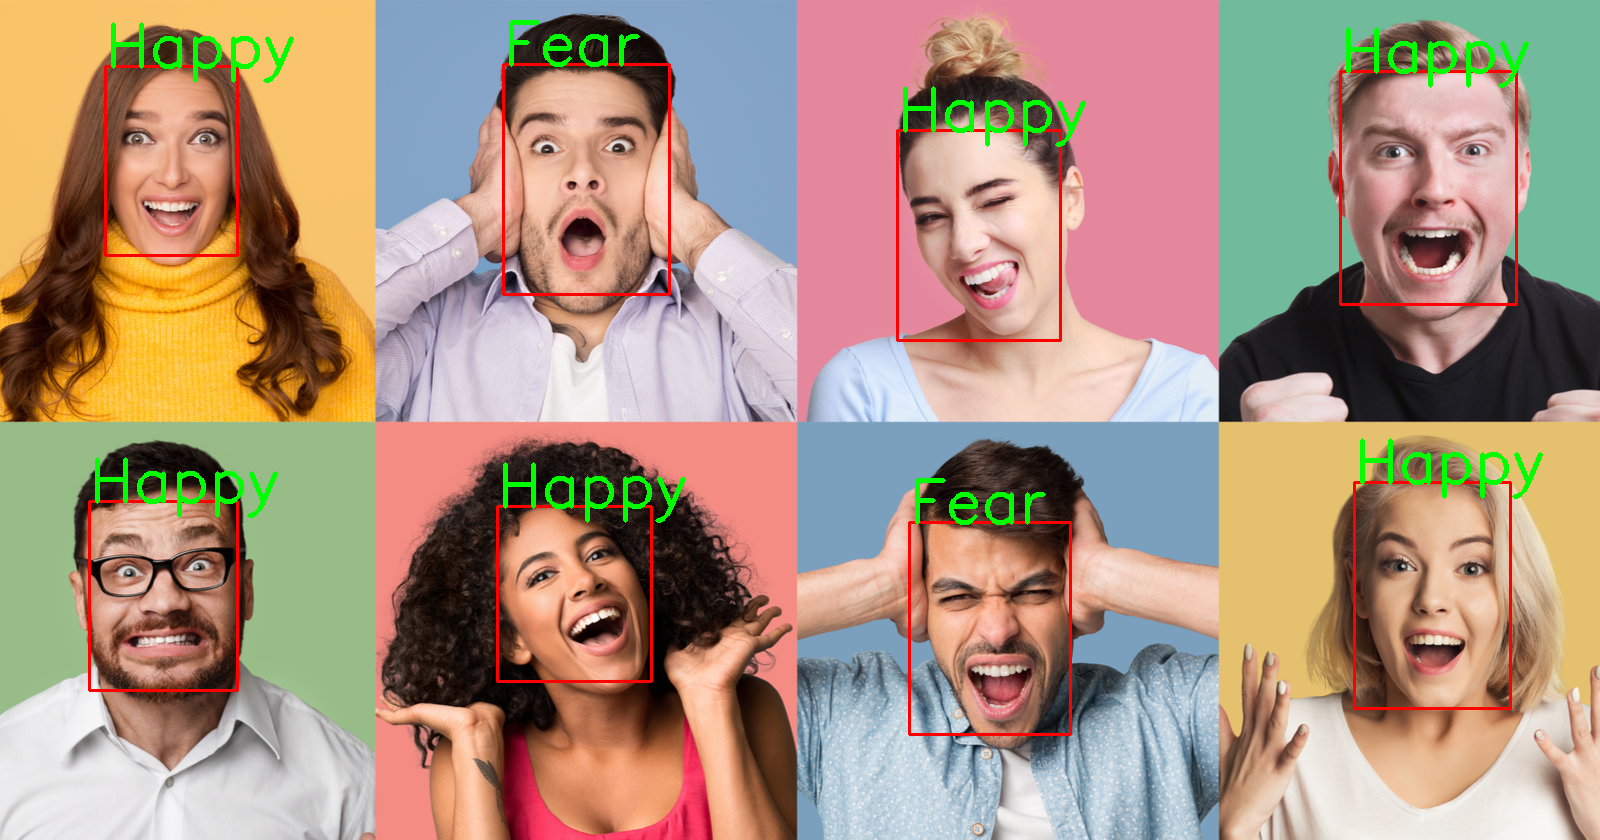

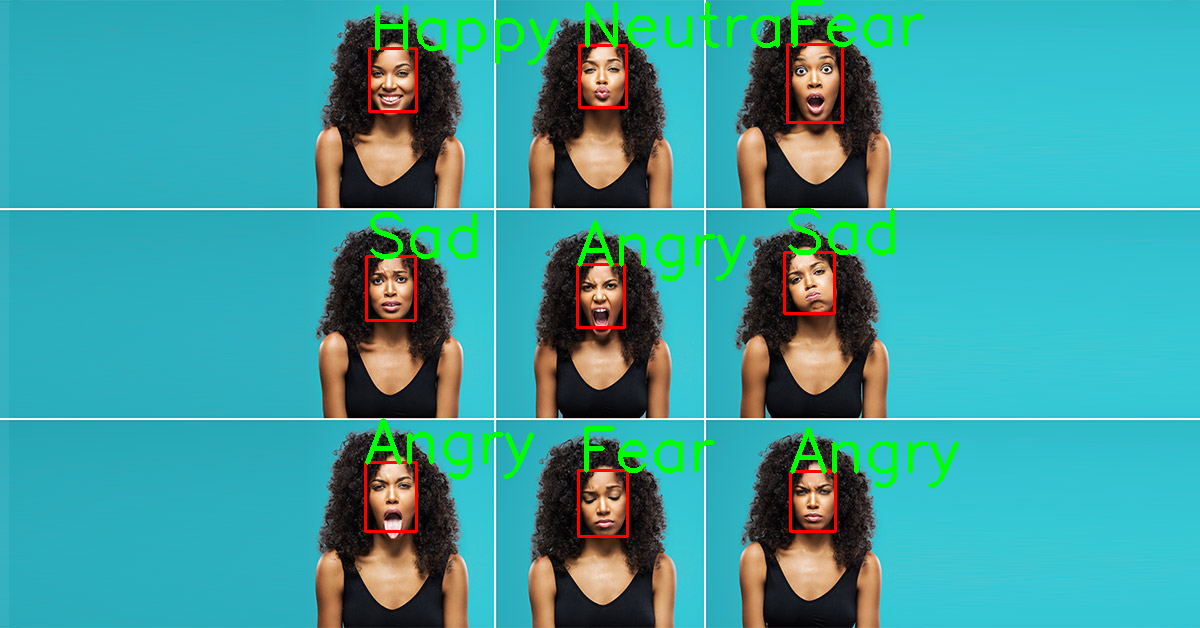

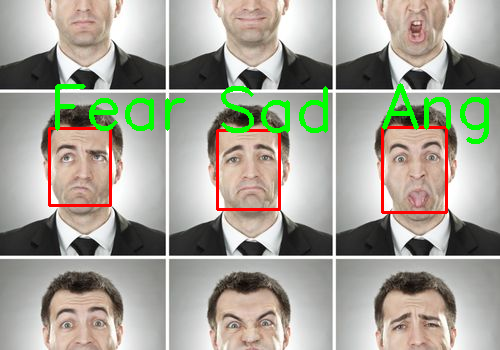

In [16]:
get_emotion("/content/1.png")
get_emotion("/content/2.jpg")
get_emotion("/content/3.jpg")

In [ ]:
model = Sequential()

# Block-1

model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(img_rows,img_cols,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-2 

model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-3

model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-4 

model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-5

model.add(Flatten())
model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-6

model.add(Dense(64,kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-7

model.add(Dense(num_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

print(model.summary())

